In [35]:
import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
#sys.path.append( os.getcwd()+'/srcDiffmap')
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import integrator
import sampler
import model

import numpy as np
from simtk import openmm, unit

import helpers
import stein

import argparse



# folder where the data is saved
dataFolderName = '/Users/zofia/github/DFM/Results/Alanine/Alanine_ManyInst/Diffmap/4/2/Data/Alanine/frontier_points_corner_change_temperature_off'
nrSteps = 5
steinStepSize = 0.01
modnr = 10

# intialize sampler class together wuth the model
mdl=model.Model('Alanine')
intg=integrator.Integrator( model=mdl, gamma=1.0 / unit.picosecond, temperature=300 * unit.kelvin, dt=2.0 * unit.femtosecond,  temperatureAlpha=300 * unit.kelvin)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')

# stein
st = stein.Stein(smpl, dataFolderName, modnr = modnr)
# change the stein parameters
st.epsilon_step=unit.Quantity(steinStepSize, smpl.model.x_unit)**2
st.kernel_scaling_parameter = 0.001
st.percentageOfLeaderParticles = 0.95 
print('Running steinIS on '+repr(len(st.qInit))+' points')
np.save(dataFolderName+'/stein_initial.npy', st.qInit)

#run stein
st.run_stein(numberOfSteinSteps = nrSteps)

np.save(dataFolderName+'/stein_final.npy', st.q)


Maximal position value in one direction is 0.86477354000000006
PBC box size set to 8.6477354000000002
626.89787892 K
Running steinIS on 10000 points
Stein iteration 0
Stein iteration 1
Stein iteration 2
Stein iteration 3
Stein iteration 4


In [36]:
import mdtraj as md

def plotSamplingDihedrals_fromData(X_FT, topology, methodName=None, color=None, title=None, leader_set=None):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=topology #md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    inp=md.Trajectory(X_FT, top)

    angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    if color is None:
        clr =[1,1,0.5]
    else:
        clr = color
        
    if leader_set is None:
        pass
    else:
        clr = np.zeros(angles.shape[0])
        clr[leader_set] += 0.1 
        
    ax.scatter(angles[:, 0], angles[:, 1], s=2, c=clr);
    ax.set_title(title)
    ax.set_xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    ax.set_ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    plt.show()



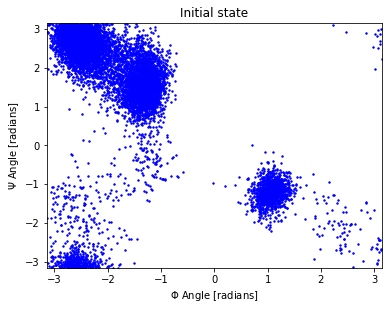

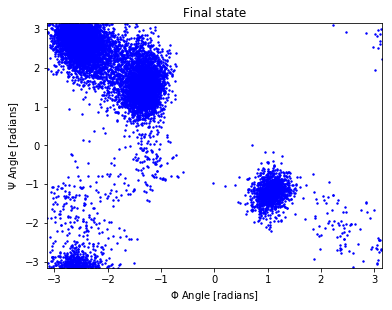

In [37]:
plotSamplingDihedrals_fromData(st.qInit, st.topology, methodName=None, color='b', title='Initial state', leader_set=None)
plotSamplingDihedrals_fromData(st.q, st.topology, methodName=None, color='b', title='Final state', leader_set=None)

# Compare free energies with reference

In [23]:
# load reference free energy profile at 300 K
reference_folder_300K='/Users/zofia/github/DFM/Results/Alanine/T300/'

FE_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE_phi.npy')
bc_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins_phi.npy')

FE_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE.npy')
bc_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins.npy')

In [24]:
def compute_dihedrals_phi(X_FT):
            psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]

            inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

            Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices])
            return Y[:,0]

def compute_dihedrals_psi(X_FT):
            psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]

            inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

            Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices])
            return Y[:,1]


Computing collective variable of trajetory of  10000 points
(101,)
(101,)


/Users/zofia/github/DFM/srcDiffmap/helpers.py:164: RuntimeWarning: divide by zero encountered in log
  free_energy= - np.log(free_energy)


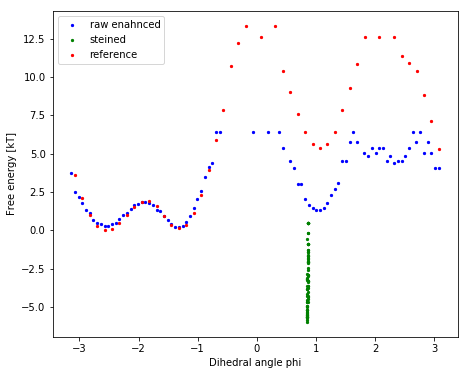

In [25]:
nrBins=100
X_short=st.X_FT

print('Computing collective variable of trajetory of  '+repr(len(st.X_FT))+' points')
cv=compute_dihedrals_phi(X_short)
cv_stein=compute_dihedrals_phi(st.q)

free_energy_raw_phi, bin_centers_raw_phi = helpers.compute_free_energy(cv, nrbins = nrBins)
free_energy_SteinIS_phi, bin_centers_SteinIS_phi = helpers.compute_free_energy(cv_stein, nrbins = nrBins)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(bin_centers_raw_phi, free_energy_raw_phi, s=5, c='b', marker='o')
ax.scatter(bin_centers_SteinIS_phi, free_energy_SteinIS_phi, s=5, c='g', marker='o')
ax.scatter(bc_ref_phi, FE_ref_phi, s=5, c='r', marker='o')
plt.legend(['raw enahnced', 'steined', 'reference'])
ax.set_xlabel('Dihedral angle phi')
ax.set_ylabel('Free energy [kT]')

plt.show()


In [ ]:

plotSamplingDihedrals_fromData(st.q, st.topology, methodName=None, color='b', title='Final state', leader_set=None)